In [1]:
import pandas as pd
import numpy as np
import pandas_profiling

In [2]:
train = pd.read_csv("../data/tabular_playground/train.csv")

In [3]:
train.isnull().sum()

PassengerId        0
Survived           0
Pclass             0
Name               0
Sex                0
Age             3292
SibSp              0
Parch              0
Ticket          4623
Fare             134
Cabin          67866
Embarked         250
dtype: int64

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

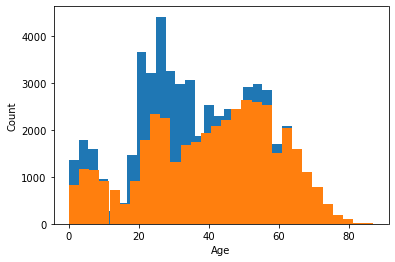

In [5]:
plt.hist(train.loc[train["Survived"] == 0, "Age"].dropna(), bins=30, label="0")
plt.hist(train.loc[train["Survived"] == 1, "Age"].dropna(), bins=30, label="1")

plt.xlabel("Age")
plt.ylabel("Count")

plt.show()

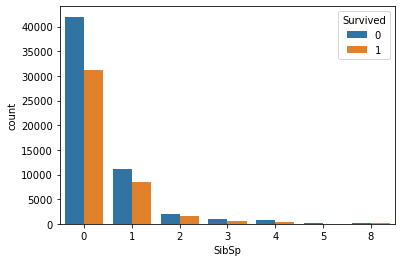

In [6]:
sns.countplot(x="SibSp", hue="Survived", data=train)
plt.legend(loc="upper right", title="Survived")
plt.show()

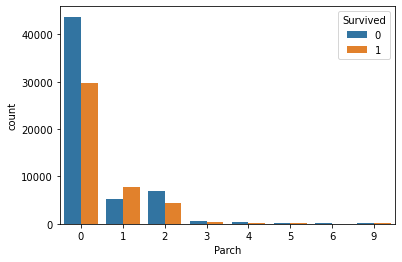

In [7]:
sns.countplot(x="Parch", hue="Survived", data=train)
plt.legend(loc='upper right', title='Survived')
plt.show()

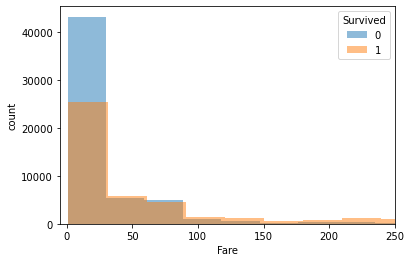

In [8]:
plt.hist(train.loc[train["Survived"] == 0, "Fare"].dropna(), bins=25, alpha=0.5, label="0")
plt.hist(train.loc[train["Survived"] == 1, "Fare"].dropna(), bins=25, alpha=0.5, label="1")

plt.xlabel("Fare")
plt.ylabel("count")
plt.legend(title="Survived")

plt.xlim(-5, 250)
plt.show()

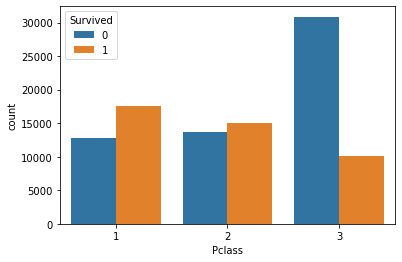

In [9]:
sns.countplot(x="Pclass", hue="Survived", data=train)
plt.show()

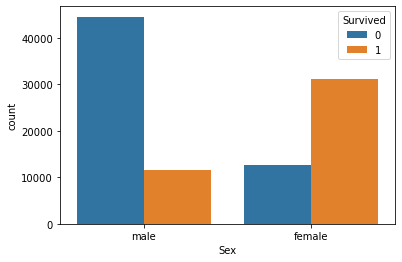

In [10]:
sns.countplot(x="Sex", hue="Survived", data=train)
plt.show()

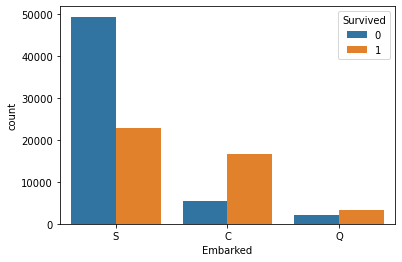

In [11]:
sns.countplot(x="Embarked", hue="Survived", data=train)
plt.show()

## 考察
- あんまり元のtitanicと変わらなさそう？
- 同じ特徴量、モデルである程度まで行けそう

In [12]:
# 家族人数を考える
train["FamilySize"] = train["Parch"] + train["SibSp"] + 1


<AxesSubplot:xlabel='FamilySize', ylabel='count'>

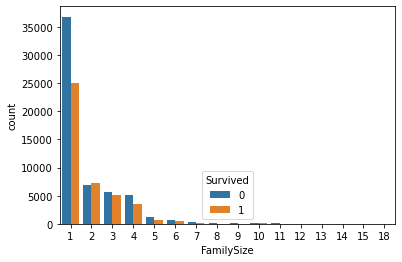

In [13]:
sns.countplot(x="FamilySize", data=train, hue="Survived")

In [14]:
# 一人かどうかも有効そう
train["IsAlone"] = 0
train.loc[train["FamilySize"] == 1, "IsAlone"] = 1

<AxesSubplot:xlabel='IsAlone', ylabel='count'>

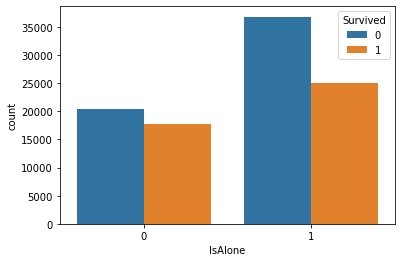

In [15]:
sns.countplot(x="IsAlone", data=train, hue="Survived")

<AxesSubplot:xlabel='Embarked', ylabel='count'>

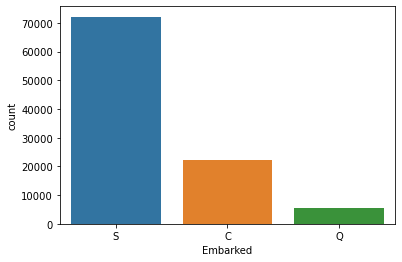

In [16]:
sns.countplot(x="Embarked", data=train)

# 考察2
- データの特徴が元のtitanicとかなり異なりそう
    - https://www.kaggle.com/carlmcbrideellis/synthanic-feature-engineering-beware
    - 身寄りのない子供の割合が増加している　孤児院の移転とかしてた？
    - 同じチケットで何人も旅行している + チケットの価格も異なる
        - `Ticket == "10867"`
    - 同じキャビンに複数人泊っており、価格も異なる（床で寝させられた？）
        - `Cabin == "C11139"`
    - `FamilySize`も微妙
        - 最大18人の家族が4組
    - データ生成時のアルゴリズムによってかなり影響がありそう
- 学習手法はPseudolabellingが有効そう
    - https://www.kaggle.com/c/tabular-playground-series-apr-2021/discussion/231738
    - テスト用データに推測したラベルを付与して学習用データにしてしまう

## 提出済みカーネルを見てEDAする

### firstNameを見てみる

In [17]:
train['FirstName'] = train.Name.map(
    lambda x: str(x.split(',')[0])
)
train['SurName'] = train.Name.map(
    lambda x: str(x.split(',')[1])
)

In [18]:
# sns.countplot(x="SurName", hue="Survived", data=train)

In [19]:
# sns.countplot(x="FirstName", hue="Survived", data=train)

In [20]:
for col in ['Name', 'FirstName', 'SurName']:
        train['Counter_' + col] = train[col].map(train.groupby(col)['PassengerId'].count().to_dict())

In [21]:
train[["Survived", "Counter_FirstName", "Counter_Name", "Counter_SurName"]]

,Survived,Counter_FirstName,Counter_Name,Counter_SurName
0,1,28,1,21
1,0,25,1,17
2,0,79,1,459
3,0,29,1,2112
4,1,16,1,1685
...,...,...,...,...
99995,1,150,1,8
99996,0,665,2,54
99997,0,10,1,931
99998,0,2,1,869


<AxesSubplot:xlabel='Counter_FirstName', ylabel='count'>

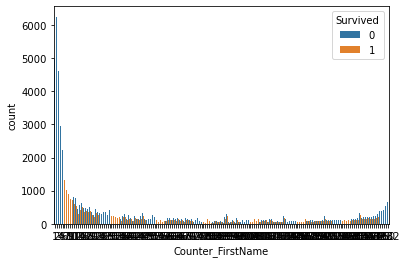

In [22]:
sns.countplot(x="Counter_FirstName", hue="Survived", data=train)

<AxesSubplot:xlabel='Counter_SurName', ylabel='count'>

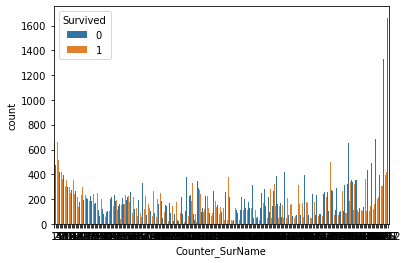

In [23]:
sns.countplot(x="Counter_SurName", hue="Survived", data=train)

In [24]:
# train.Ticket = train.Ticket.map(lambda x:str(x).split()[0] if len(str(x).split()) > 1 else np.nan)
# train['Counter_Ticket'] = train["Ticket"].map(train.groupby("Ticket")['PassengerId'].count().to_dict())
# sns.countplot(x="Counter_Ticket", hue="Survived", data=train)

In [25]:
# sns.countplot(x="Ticket", hue="Survived", data=train)

In [26]:
# train.Cabin = train.Cabin.map(lambda x:str(x).split()[0])
# train['Counter_Cabin'] = train["Cabin"].map(train.groupby("Cabin")['PassengerId'].count().to_dict())
# sns.countplot(x="Counter_Cabin", hue="Survived", data=train)

In [27]:
train["Cabin"]

0        C12239
1           NaN
2           NaN
3           NaN
4           NaN
          ...  
99995    D17243
99996       NaN
99997       NaN
99998       NaN
99999       NaN
Name: Cabin, Length: 100000, dtype: object

In [28]:
def convertTextToStrAndNumeric(feature):
    """
    与えられた特徴を文字列と数字部分に分割
    """
    string = ""
    numeric = ""
    feature = str(feature).replace(".", "").replace("/", "").replace(" ", "")
    for char in feature:
        if char.isnumeric():
            numeric += char
        else:
            string += char
    return string, numeric

In [29]:
train["Ticket_type"] = train["Ticket"].map(lambda x: convertTextToStrAndNumeric(x)[0])
train["Ticket_number"] = train["Ticket"].map(lambda x: convertTextToStrAndNumeric(x)[1])

train[["Ticket_type", "Ticket_number"]]


,Ticket_type,Ticket_number
0,,209245
1,,27323
2,CA,457703
3,A,10866
4,,427635
...,...,...
99995,PC,15008
99996,,13273
99997,nan,
99998,,458654


<AxesSubplot:xlabel='Ticket_type', ylabel='count'>

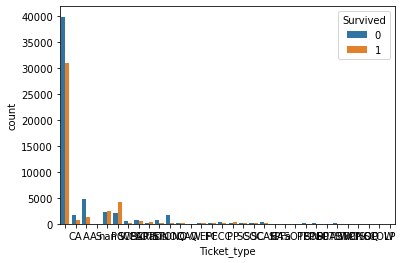

In [30]:
sns.countplot(x="Ticket_type", hue="Survived", data=train)

In [31]:
# sns.countplot(x="Ticket_number", hue="Survived", data=train)

In [32]:
train["Cabin_type"] = train["Cabin"].map(lambda x: convertTextToStrAndNumeric(x)[0])
train["Cabin_number"] = train["Cabin"].map(lambda x: convertTextToStrAndNumeric(x)[1])

train[["Cabin_type", "Cabin_number"]]


,Cabin_type,Cabin_number
0,C,12239
1,nan,
2,nan,
3,nan,
4,nan,
...,...,...
99995,D,17243
99996,nan,
99997,nan,
99998,nan,


<AxesSubplot:xlabel='Cabin_type', ylabel='count'>

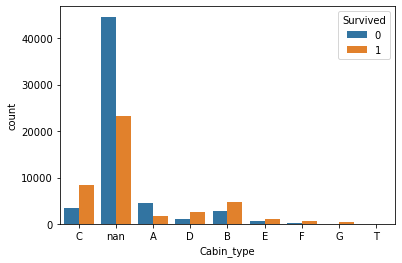

In [33]:
sns.countplot(x="Cabin_type", hue="Survived", data=train)

In [34]:
# sns.countplot(x="Cabin_number", hue="Survived", data=train)

## 考察
- 繰り返し用いられているfirstname、surnameに関連がありそう
- 名前全体は繰り返し用いられていないが、名前の一部は再利用されている？